Google Dataset

A time Series analysis dataset

This dataset is about Google stock which is a time series dataset that includes features like Close and Volume prices.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"raretears","key":"35e249f9a1c2c63a71b020f5ac1939f8"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! kaggle datasets download -d mbsoroush/google-dataset

Dataset URL: https://www.kaggle.com/datasets/mbsoroush/google-dataset
License(s): other
google-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! unzip '/content/google-dataset.zip' -d '/content/google-dataset'

Archive:  /content/google-dataset.zip
replace /content/google-dataset/GOOG.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Библиотеки

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


## Загрузка и подготовка данных

In [7]:
df = pd.read_csv('/content/google-dataset/GOOG.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.7+ KB


In [9]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


Поменяем тип данных столбца date на datetime

In [10]:
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)

In [11]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


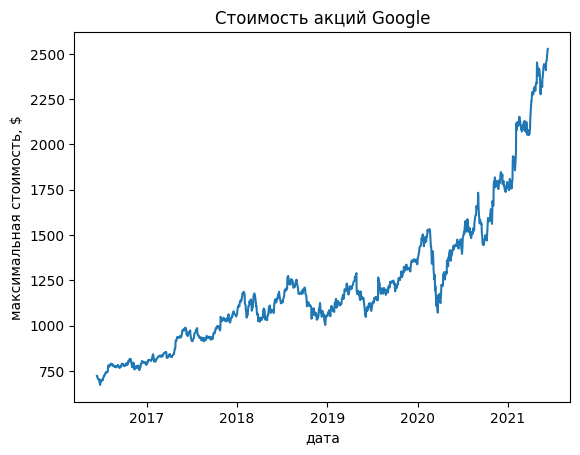

In [12]:
plt.plot(df['date'], df['high'])
plt.xlabel('дата')
plt.ylabel('максимальная стоимость, $')

plt.title('Стоимость акций Google')
plt.show()

Данные хорошие, менять ничего не будем

Применим MinMaxScaler для нормализации целевого столбца

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

df['high'] = scaler.fit_transform(df['high'].values.reshape(-1, 1))

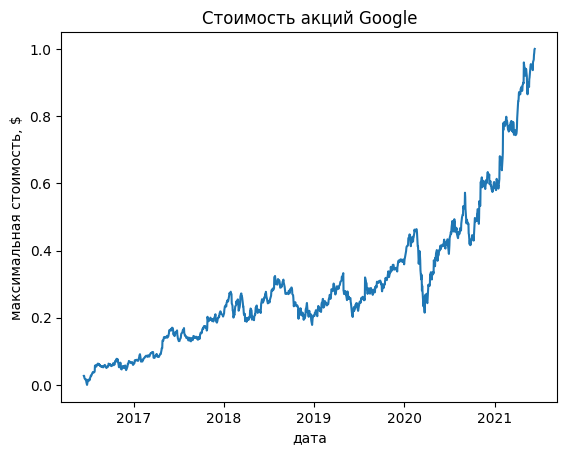

In [14]:
plt.plot(df['date'], df['high'])
plt.xlabel('дата')
plt.ylabel('максимальная стоимость, $')

plt.title('Стоимость акций Google')
plt.show()

Разделим исходную выборку на две последовательные части: тренировочную (в нее входят и тренировочные и тестовые данные) и валидационную.

In [15]:
test_ratio = 0.2
split_row = len(df) - int(test_ratio*len(df))
train_df = df.iloc[:split_row]
test_df = df.iloc[split_row:]

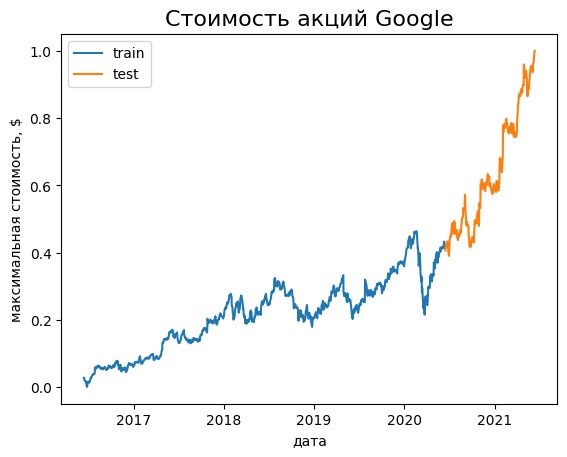

In [16]:
fig, ax = plt.subplots(1)
ax.plot(train_df['date'], train_df['high'], label='train')
ax.plot(test_df['date'], test_df['high'], label='test')
ax.set_ylabel('максимальная стоимость, $')
ax.set_xlabel('дата')
ax.set_title('Стоимость акций Google', fontsize=16)
ax.legend()

fig.show()

In [17]:
train_data = train_df['high'].values
test_data = test_df['high'].values

In [18]:
window = 20

X = []
y = []

for i in range(len(train_data)-window):
    X.append(train_data[i:i+window])
    y.append(train_data[i+window])

X = np.array(X)
y = np.array(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

Данные подготовлены, теперь можем перейти к обучению

## Обучение модели

In [20]:
def build_model():
  input = Input(shape=(window, 1))
  hidden = LSTM(100)(input)
  output = Dense(1, activation='linear')(hidden)

  model = Model(inputs=input, outputs=output)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])

  return model

In [21]:
model = build_model()

checkpoint_path = "./best-model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=20, verbose=1)

tensorboard = TensorBoard(log_dir="./logs")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=32,
    verbose=1,
    callbacks=[
        checkpoint,
        early_stopping,
        tensorboard
    ],
)

Epoch 1/500
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0252 - mae: 0.1188
Epoch 1: val_loss improved from inf to 0.00112, saving model to ./best-model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0234 - mae: 0.1133 - val_loss: 0.0011 - val_mae: 0.0277
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - mae: 0.0278
Epoch 2: val_loss improved from 0.00112 to 0.00039, saving model to ./best-model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - mae: 0.0277 - val_loss: 3.9394e-04 - val_mae: 0.0156
Epoch 3/500
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.9861e-04 - mae: 0.0154
Epoch 3: val_loss improved from 0.00039 to 0.00033, saving model to ./best-model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9459e-04 - mae: 0.0153 - val_loss: 3.2627e-04 - val_mae: 0.0119
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1457e-04 - mae: 0.0130
Epoch 4: val_loss improved from 0.00033 to 0.00032, saving model to ./best-model.

In [22]:
best_model = load_model(checkpoint_path)
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)

In [23]:
X_val = []
y_val = []

for i in range(len(test_data)-window):
    X_val.append(test_data[i:i+window])
    y_val.append(test_data[i+window])

X_val = np.array(X_val)
y_val = np.array(y_val)

In [24]:
predictions = best_model.predict(X_val)
inv_predictions = scaler.inverse_transform(predictions)
inv_real = scaler.inverse_transform(y_val.reshape(-1, 1))

predictions = inv_predictions.reshape(1, -1)[0]
real_values = inv_real

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


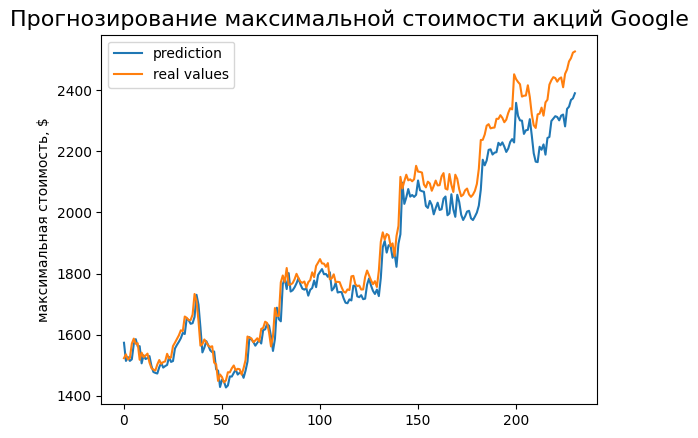

In [27]:
fig, ax = plt.subplots(1)
ax.plot(predictions, label='prediction')
ax.plot(real_values, label='real values')
ax.set_ylabel('максимальная стоимость, $')
ax.set_title('Прогнозирование максимальной стоимости акций Google', fontsize=16)
ax.legend()

fig.show()

In [26]:
print('MAE на валидации: %.1f' % mean_absolute_error(real_values, predictions))

MAE на валидации: 54.8


Ошибка составляет всего лишь 2,2%. Модель отлично справилась с задачей